Confusion Matrix:
 [[427  43   1]
 [ 70 436   4]
 [  4   4 432]]
Accuracy: 0.9113300492610837
Precision: [0.85229541 0.90269151 0.98855835]
Recall: [0.90658174 0.85490196 0.98181818]
F-measure: [0.87860082 0.87814703 0.98517674]


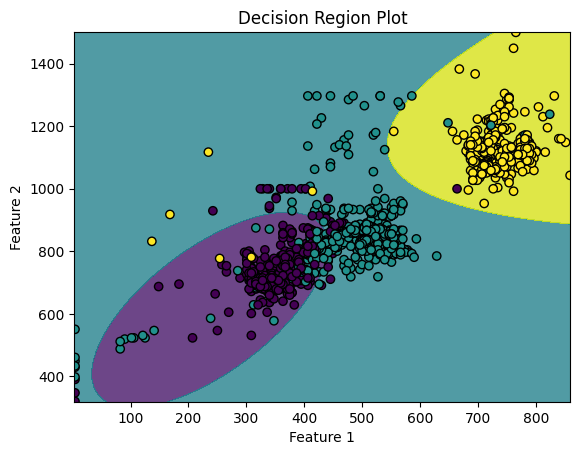

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function to load data from text files using genfromtxt for flexibility
def load_class_data(file_path):
    return np.genfromtxt(file_path, delimiter=' ')  # Adjust delimiter as needed

# Load the datasets
class1 = load_class_data('class1.txt')
class2 = load_class_data('class2.txt')
class3 = load_class_data('class3.txt')

# Combine the data
X = np.vstack((class1, class2, class3))
y = np.concatenate([np.zeros(len(class1)), np.ones(len(class2)), 2 * np.ones(len(class3))])

# Split the data into training and testing sets (70% training, 30% testing)
def train_test_split(X, y, test_size=0.2):  # Reduce test size to 20%
    n = len(y)
    indices = np.random.permutation(n)
    test_size = int(n * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], y[train_indices], X[test_indices], y[test_indices]

X_train, y_train, X_test, y_test = train_test_split(X, y)

# Function to calculate Gaussian PDF (optimized)
def gaussian_pdf(X, mean, cov):
    d = X.shape[1]
    cov += np.eye(d) * 1e-6  # Add a small value to the diagonal for numerical stability
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    norm_factor = 1 / np.sqrt((2 * np.pi) ** d * det_cov)

    diff = X - mean
    exp_factor = -0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1)

    return norm_factor * np.exp(exp_factor)

# Function to calculate the class conditional probabilities and classify
def bayes_classifier(X, means, covariances, priors):
    n_classes = len(means)
    n_samples = X.shape[0]
    posteriors = np.zeros((n_samples, n_classes))

    for i in range(n_classes):
        posteriors[:, i] = priors[i] * gaussian_pdf(X, means[i], covariances[i])

    return np.argmax(posteriors, axis=1)

# Calculate means, covariances, and priors
def calculate_parameters(X, y):
    n_classes = np.unique(y).shape[0]
    means = np.zeros((n_classes, X.shape[1]))
    covariances = np.zeros((n_classes, X.shape[1], X.shape[1]))
    priors = np.zeros(n_classes)

    for i in range(n_classes):
        X_class = X[y == i]
        means[i] = np.mean(X_class, axis=0)
        covariances[i] = np.cov(X_class, rowvar=False)
        priors[i] = X_class.shape[0] / X.shape[0]

    return means, covariances, priors

# Train the classifier
means, covariances, priors = calculate_parameters(X_train, y_train)

# Classify the test set
y_pred = bayes_classifier(X_test, means, covariances, priors)

# Convert predictions and true labels to integer type
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Calculate metrics
def confusion_matrix(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm

cm = confusion_matrix(y_test, y_pred, 3)

# Calculate accuracy, precision, recall, and F-measure
def calculate_metrics(cm):
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f_measure = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f_measure

accuracy, precision, recall, f_measure = calculate_metrics(cm)

# Print results
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)

# Plot decision regions with increased step size
def plot_decision_regions(X, y, classifier, means, covariances, priors):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Increase the step size to 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))

    # Classify the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier(grid_points, means, covariances, priors)

    # Reshape the result to match the meshgrid
    Z = Z.reshape(xx.shape)

    # Plot the decision regions
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title('Decision Region Plot')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_decision_regions(X_test, y_test, bayes_classifier, means, covariances, priors)
